In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

pd.set_option('display.precision', 3)

In [14]:
# Extra imports

from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz

from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB

from time import time
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## Reading csv

In [17]:
ILDS = read_csv("ILDS.csv", delimiter=',')

ILDS.head()

ILDS['Female'] = ILDS['Female'].astype('category')
ILDS['target'] = ILDS['target'].astype('category')

ILDS.shape

(460, 17)

In [18]:
ILDS.describe(include='all')

,Unnamed: 0,Age,Female,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AR,target,IB,log_TB,log_DB,log_IB,log_Alkphos
count,460.000,460.000,460.0,460.000,460.000,460.000,460.000,460.000,460.000,460.000,460.000,460.0,460.000,460.000,460.000,459.000,460.000
unique,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.0,NaN,NaN,NaN,NaN,NaN
mean,230.061,44.898,NaN,3.101,1.430,279.787,69.839,88.435,6.423,3.109,0.942,NaN,1.671,0.454,-0.669,0.007,5.479
std,133.635,16.342,NaN,5.119,2.673,211.895,138.117,152.444,1.054,0.794,0.318,NaN,2.491,1.003,1.315,0.852,0.497
min,0.000,4.000,NaN,0.400,0.100,75.000,10.000,11.000,2.700,0.900,0.300,NaN,-0.400,-0.916,-2.303,-1.204,4.317
25%,114.750,33.000,NaN,0.800,0.200,176.000,23.000,25.000,5.700,2.500,0.700,NaN,0.600,-0.223,-1.609,-0.511,5.170
50%,229.500,45.000,NaN,1.000,0.300,208.000,34.000,41.000,6.500,3.100,0.910,NaN,0.700,0.000,-1.204,-0.357,5.338
75%,346.250,58.000,NaN,2.600,1.200,290.000,59.250,82.250,7.100,3.700,1.100,NaN,1.400,0.956,0.182,0.336,5.670


## Train-validation-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(ILDS.loc[:,:'AR'], ILDS.loc[:,'target'],  
                                                    test_size=0.2, stratify=ILDS.loc[:,'target'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

X_train.shape, X_val.shape, X_test.shape


((276, 11), (92, 11), (92, 11))

## Metrics

In [20]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]
    
    

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

## Decision tree

In [21]:
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

In [22]:
y_pred = model_tree.predict(X_val)

results.loc['DT-default',:] = compute_metrics(y_val, y_pred)

confusion(y_val, y_pred)

predicted,0,1
target,,
0,49,16
1,18,9


Evaluation on validation

In [23]:
print(classification_report(y_val, y_pred, target_names=['No', 'yes'],))

results

              precision    recall  f1-score   support

          No       0.73      0.75      0.74        65
         yes       0.36      0.33      0.35        27

    accuracy                           0.63        92
   macro avg       0.55      0.54      0.54        92
weighted avg       0.62      0.63      0.63        92



,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-default,0.63,0.346,0.742,0.544


Evaluation on train

In [24]:
y_pred_train = model_tree.predict(X_train)

confusion(y_train,y_pred_train)

print(classification_report(y_train, y_pred_train, target_names=['no', 'yes'],))

              precision    recall  f1-score   support

          no       1.00      1.00      1.00       197
         yes       1.00      1.00      1.00        79

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [25]:
print('Tree depht: {}\nNodes: {}'.format(model_tree.tree_.max_depth, model_tree.tree_.node_count))

Tree depht: 12
Nodes: 109


Checking hyperparameters

In [26]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['auto', 'sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=5,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:21.868540


Checking the f1 scores of all the hyperparameters

In [27]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
586,entropy,None,None,3,2,0.656,0.800,0.512,0.718
589,entropy,None,None,3,5,0.656,0.804,0.508,0.721
798,entropy,10,None,5,4,0.653,0.796,0.511,0.714
788,entropy,10,None,3,4,0.651,0.797,0.505,0.714
796,entropy,10,None,5,2,0.648,0.802,0.494,0.717


Checking the characteristics of the best model

In [28]:
best_params = model_5CV.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

Applying the best model

In [29]:
y_pred = model_5CV.predict(X_val)

results.loc['DT-best',:] = compute_metrics(y_val, y_pred)

confusion(y_val,y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
DT-default,0.63,0.346,0.742,0.544


# Random Forest

In [30]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

pred = model_rf1.predict(X_train)

confusion(y_train,pred)

print(classification_report(y_train, pred, target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf1.oob_score_)

              precision    recall  f1-score   support

          no       1.00      1.00      1.00       197
         yes       1.00      1.00      1.00        79

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

OOB accuracy= 0.6992753623188406


In [31]:
y_pred = model_rf1.predict(X_val)
print('Validation Accuracy:{}'.format(model_rf1.score(X_val,y_val)))
results.loc['RF-default',:] = compute_metrics(y_val,y_pred)
confusion(y_val,y_pred)

Validation Accuracy:0.6413043478260869


predicted,0,1
target,,
0,56,9
1,24,3


In [32]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
DT-default,0.63,0.346,0.742,0.544
RF-default,0.641,0.154,0.772,0.463


Including class weights

In [33]:
model_rf2 = RandomForestClassifier(n_estimators=100, 
                                   oob_score=True, 
                                   class_weight='balanced').fit(X_train, y_train)

pred = model_rf2.predict(X_train)

confusion(y_train, pred)

print(classification_report(y_train,pred,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

              precision    recall  f1-score   support

          no       1.00      1.00      1.00       197
         yes       1.00      1.00      1.00        79

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

OOB accuracy= 0.717391304347826


In [34]:
y_pred = model_rf2.predict(X_val)

results.loc['RF-balance',:] = compute_metrics(y_val,y_pred)

confusion(y_val,y_pred)

predicted,0,1
target,,
0,60,5
1,24,3


In [35]:
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
DT-default,0.63,0.346,0.742,0.544
RF-balance,0.685,0.171,0.805,0.488
RF-default,0.641,0.154,0.772,0.463


In [36]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200,None]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf, 
                       'class_weight':balance
                   },
                   cv=5,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:10.524186


In [37]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
24,None,4,4,0.626,0.786,0.466,0.696
22,100,6,6,0.625,0.758,0.491,0.674
28,None,6,4,0.623,0.760,0.486,0.674
40,None,4,4,0.620,0.780,0.460,0.689
20,100,6,4,0.615,0.754,0.475,0.667


In [38]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200}

In [39]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = rf_model_tuned.predict(X_val)

results.loc['RF-best', :] = compute_metrics(y_val, y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
RF-best,0.663,0.415,0.763,0.589
DT-default,0.63,0.346,0.742,0.544
RF-balance,0.685,0.171,0.805,0.488
RF-default,0.641,0.154,0.772,0.463


In [40]:
confusion(y_val, y_pred)

predicted,0,1
target,,
0,50,15
1,16,11


# Extra tree classifier

In [41]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

y_pred = extra_trees.predict(X_val)

results.loc['extra_trees',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
RF-best,0.663,0.415,0.763,0.589
extra_trees,0.728,0.324,0.83,0.577
DT-default,0.63,0.346,0.742,0.544
RF-balance,0.685,0.171,0.805,0.488
RF-default,0.641,0.154,0.772,0.463


In [42]:
init_time = time()

rf_model = ExtraTreesClassifier(class_weight='balanced')

ntrees = [150, None]
max_depth = [100, None]
min_samples_split = [4, 6]
min_samples_leaf = [2, 4]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'class_weight': balance
                   },
                   cv=5,
                   return_train_score=True,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:00:03.802985


In [43]:
pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_f1_mac,mean_test_f1_class_0,mean_test_f1_class_1,mean_test_acc
34,100,2,6,0.658,0.781,0.535,0.703
40,None,2,4,0.653,0.793,0.514,0.710
32,100,2,4,0.652,0.794,0.510,0.710
24,None,2,4,0.646,0.786,0.506,0.703
42,None,2,6,0.644,0.771,0.517,0.692


In [44]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 150}

In [45]:
extra_trees_best = ExtraTreesClassifier(**best_params)
extra_trees_best.fit(X_train,y_train)

y_pred = extra_trees_best.predict(X_val)

results.loc['extra_trees-best',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
extra_trees-best,0.674,0.423,0.773,0.598
RF-best,0.663,0.415,0.763,0.589
extra_trees,0.728,0.324,0.83,0.577
DT-default,0.63,0.346,0.742,0.544
RF-balance,0.685,0.171,0.805,0.488
RF-default,0.641,0.154,0.772,0.463


# Feature importance

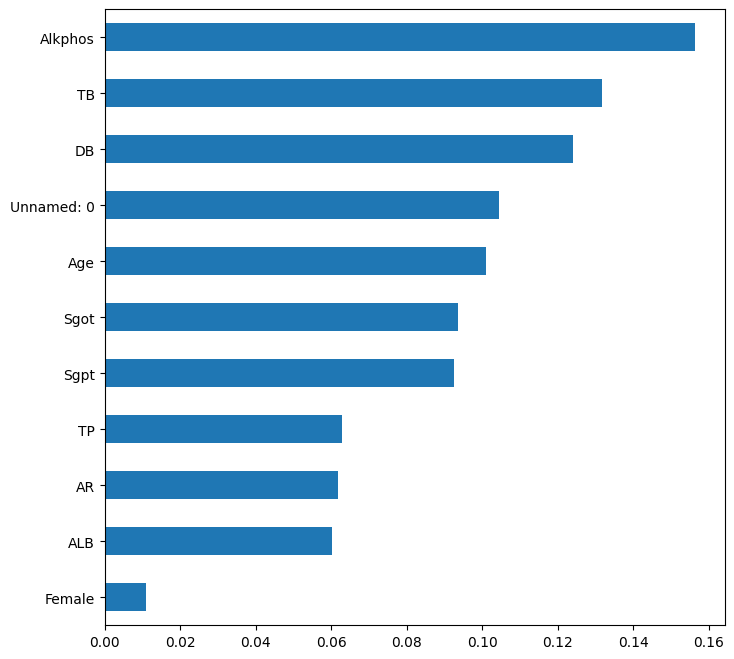

In [46]:
var_imp = pd.DataFrame({'importance': rf_model_tuned.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False);

# Ensembles

In [47]:
gauss_nb = GaussianNB()
gauss_nb.fit(X_train,y_train)

y_pred = gauss_nb.predict(X_val)

results.loc['GaussianNB-default',:] = compute_metrics(y_val,y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
DT-best,0.717,0.5,0.803,0.652
GaussianNB-default,0.652,0.628,0.673,0.651
extra_trees-best,0.674,0.423,0.773,0.598
RF-best,0.663,0.415,0.763,0.589
extra_trees,0.728,0.324,0.83,0.577
DT-default,0.63,0.346,0.742,0.544
RF-balance,0.685,0.171,0.805,0.488
RF-default,0.641,0.154,0.772,0.463


In [48]:
voting_hard = VotingClassifier([('dt', model_tree), ('rf', model_rf1),
                                ('gnb', gauss_nb),('extratrees',extra_trees)])
voting_hard.fit(X_train, y_train)

y_pred = voting_hard.predict(X_val)

results.loc['voting_hard', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-default','GaussianNB-default','RF-default','extra_trees','voting_hard'],:].sort_values(
    by='F1-score (class 1)',ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
GaussianNB-default,0.652,0.628,0.673,0.651
DT-default,0.63,0.346,0.742,0.544
extra_trees,0.728,0.324,0.83,0.577
voting_hard,0.717,0.316,0.822,0.569
RF-default,0.641,0.154,0.772,0.463


In [49]:
voting_soft = VotingClassifier([('dt', model_tree), ('rf', model_rf1),
                                ('gnb', gauss_nb),('extratrees',extra_trees)],voting='soft')
voting_soft.fit(X_train, y_train)

y_pred = voting_soft.predict(X_val)

results.loc['voting_soft', :] = compute_metrics(y_val, y_pred)

results.loc[['DT-default','GaussianNB-default','RF-default','extra_trees','voting_hard','voting_soft'],:].sort_values(
    by='F1-score (class 1)',ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
GaussianNB-default,0.652,0.628,0.673,0.651
voting_soft,0.696,0.417,0.794,0.605
DT-default,0.63,0.346,0.742,0.544
extra_trees,0.728,0.324,0.83,0.577
voting_hard,0.717,0.316,0.822,0.569
RF-default,0.641,0.154,0.772,0.463


# Test

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Unnamed: 0
